In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


drive_mount = False
if drive_mount:
  from google.colab import drive
  drive.mount('/content/drive/')
  DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/COMP0036/datasets"
  MODEL_DIR = "/content/drive/MyDrive/Colab_Notebooks/COMP0036/models"
else:
  DATA_DIR = "../datasets"
  MODEL_DIR = "../models"
EPL_TRAINING_DATA_CSV = DATA_DIR + "/epl-training.csv"
EPL_TEST_DATA_CSV = DATA_DIR + "/sample-submission.csv"


# Read the CSV file
epl_training_df = pd.read_csv(EPL_TRAINING_DATA_CSV)
# epl_test_df = pd.read_csv(EPL_TEST_DATA_CSV).dropna()

epl_training_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HY,AY,HR,AR,HomeTeamExpenditure,HomeTeamIncome,HomeTeamBalance,AwayTeamExpenditure,AwayTeamIncome,AwayTeamBalance
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,1.0,2.0,0.0,0.0,20.80,0.532,-20.27,20.28,1.460,-18.810
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,1.0,2.0,0.0,0.0,52.39,37.720,-14.67,18.65,42.400,23.750
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,5.0,3.0,1.0,0.0,19.00,26.280,7.28,33.47,10.000,-23.470
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,1.0,1.0,0.0,0.0,13.33,6.880,-6.45,0.00,0.145,0.145
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,1.0,3.0,0.0,0.0,53.15,12.330,-40.82,34.48,35.550,1.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,2023-10-29,West Ham,Everton,0.0,1.0,A,0.0,0.0,D,S Attwell,...,4.0,1.0,0.0,0.0,137.56,156.400,18.84,40.50,82.800,42.300
8836,2023-10-29,Aston Villa,Luton,3.0,1.0,H,1.0,0.0,H,J Brooks,...,3.0,2.0,0.0,0.0,93.00,32.550,-60.45,22.75,0.000,-22.750
8837,2023-10-29,Brighton,Fulham,1.0,1.0,D,1.0,0.0,H,M Salisbury,...,0.0,3.0,0.0,0.0,100.35,195.900,95.55,68.47,52.600,-15.870
8838,2023-10-29,Liverpool,Nott'm Forest,3.0,0.0,H,2.0,0.0,H,C Salisbury,...,2.0,3.0,0.0,0.0,172.00,60.700,-111.30,122.05,64.820,-57.230


## Data Preprocessing

### Elo and Elo Delta

In [16]:
import pandas as pd

# Define a function to calculate the expected outcome of the match
def calculate_expected_score(ra, rb):
    return 1 / (1 + 10 ** ((rb - ra) / 400))

# Define a function to update the Elo rating
def update_elo(ra, rb, score, k=30):
    ea = calculate_expected_score(ra, rb)
    eb = calculate_expected_score(rb, ra)
    new_ra = ra + k * (score - ea)
    new_rb = rb + k * ((1 - score) - eb)
    return new_ra, new_rb

# Initialize a dictionary to store Elo scores for each team
elo_dict = {}

# Function to calculate Elo deltas
def calculate_elo_deltas(team, num_games):
    if team not in elo_history or len(elo_history[team]) < num_games:
        return 0  # Not enough history
    return elo_history[team][-2] - elo_history[team][-num_games-2]

# Initialize a dictionary to store Elo history for each team
elo_history = {}

# This function will be called for each row in the dataframe to update the Elo scores
def process_row(row):
    home_team, away_team = row['HomeTeam'], row['AwayTeam']
    home_goals, away_goals = row['FTHG'], row['FTAG']
    # Initialize teams with an Elo score of 1500 if they don't have one already
    if home_team not in elo_dict:
        elo_dict[home_team] = 1500
    if away_team not in elo_dict:
        elo_dict[away_team] = 1500

    # Determine match outcome for Elo calculation (1 = home win, 0.5 = draw, 0 = away win)
    if home_goals > away_goals:
        score = 1
    elif home_goals < away_goals:
        score = 0
    else:
        score = 0.5

    # Update Elo scores
    curr_home_elo, curr_away_elo = elo_dict[home_team], elo_dict[away_team]
    elo_diff = curr_home_elo - curr_away_elo
    new_home_elo, new_away_elo = update_elo(curr_home_elo, curr_away_elo, score)
    elo_dict[home_team], elo_dict[away_team] = new_home_elo, new_away_elo

    # Update Elo history
    elo_history.setdefault(home_team, [1500] * 11).append(new_home_elo)
    elo_history.setdefault(away_team, [1500] * 11).append(new_away_elo)

    # Calculate Elo deltas
    home_elo_deltas = [calculate_elo_deltas(home_team, i) for i in [1, 5, 10]]
    away_elo_deltas = [calculate_elo_deltas(away_team, i) for i in [1, 5, 10]]

    return pd.Series([new_home_elo, new_away_elo] + [curr_home_elo, curr_away_elo, elo_diff] + home_elo_deltas + away_elo_deltas)

# Example usage:
# Assuming `matches_df` is your dataframe with historical match information
columns = ['AfterMatchHomeElo', 'AfterMatchAwayElo', 'HomeElo', 'AwayElo', 'EloDiff', 'HomeEloDelta_1', 'HomeEloDelta_5', 'HomeEloDelta_10', 'AwayEloDelta_1', 'AwayEloDelta_5', 'AwayEloDelta_10']
epl_training_df[columns] = epl_training_df.apply(process_row, axis=1)
elo_df = epl_training_df[columns + ["FTR"]].drop(['AfterMatchHomeElo', 'AfterMatchAwayElo'], axis=1)

# target_column = 'FTR'
# label_encoder = LabelEncoder()
# elo_df[target_column] = label_encoder.fit_transform(elo_df[target_column])

elo_df

,HomeElo,AwayElo,EloDiff,HomeEloDelta_1,HomeEloDelta_5,HomeEloDelta_10,AwayEloDelta_1,AwayEloDelta_5,AwayEloDelta_10,FTR
0,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,H
1,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,H
2,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A
3,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,D
4,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,H
...,...,...,...,...,...,...,...,...,...,...
8835,1569.364767,1484.013329,85.351438,-10.853871,-9.813534,16.468218,-5.350927,9.244012,-16.467707,A
8836,1689.671042,1454.968736,234.702306,10.853871,41.644139,50.697609,3.218548,0.147536,-45.031264,H
8837,1654.830595,1540.074128,114.756466,-8.442841,4.854909,6.971824,-9.121904,-4.423589,-6.586610,D
8838,1760.063825,1524.257614,235.806211,5.350927,-5.529845,5.176082,-3.218548,-2.847001,13.119662,H


In [18]:
epl_training_df = epl_training_df.drop(['AfterMatchHomeElo', 'AfterMatchAwayElo'], axis=1, errors='ignore')
epl_training_df.to_csv(f'../processed_df/epl_training_with_elo.csv', index=False)
epl_training_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AwayTeamBalance,HomeElo,AwayElo,EloDiff,HomeEloDelta_1,HomeEloDelta_5,HomeEloDelta_10,AwayEloDelta_1,AwayEloDelta_5,AwayEloDelta_10
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,-18.810,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,23.750,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,-23.470,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,0.145,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,1.070,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,2023-10-29,West Ham,Everton,0.0,1.0,A,0.0,0.0,D,S Attwell,...,42.300,1569.364767,1484.013329,85.351438,-10.853871,-9.813534,16.468218,-5.350927,9.244012,-16.467707
8836,2023-10-29,Aston Villa,Luton,3.0,1.0,H,1.0,0.0,H,J Brooks,...,-22.750,1689.671042,1454.968736,234.702306,10.853871,41.644139,50.697609,3.218548,0.147536,-45.031264
8837,2023-10-29,Brighton,Fulham,1.0,1.0,D,1.0,0.0,H,M Salisbury,...,-15.870,1654.830595,1540.074128,114.756466,-8.442841,4.854909,6.971824,-9.121904,-4.423589,-6.586610
8838,2023-10-29,Liverpool,Nott'm Forest,3.0,0.0,H,2.0,0.0,H,C Salisbury,...,-57.230,1760.063825,1524.257614,235.806211,5.350927,-5.529845,5.176082,-3.218548,-2.847001,13.119662


### Elo history

In [10]:
def add_history(df, n):
    # Sort the DataFrame by Date to ensure correct historical data
    df = df.sort_values(by='Date')

    # Create new columns for historical ELO and FTR
    for i in range(1, n + 1):
        df[f'HomeElo_prev_{i}'] = df.groupby('HomeTeam')['HomeElo'].shift(i)
        df[f'AwayElo_prev_{i}'] = df.groupby('AwayTeam')['AwayElo'].shift(i)
        df[f'HomeFTR_prev_{i}'] = df.groupby('HomeTeam')['FTR'].shift(i)
        df[f'AwayFTR_prev_{i}'] = df.groupby('AwayTeam')['FTR'].shift(i)

    # Fill NaN values for ELO with 1500 and for FTR with 'D'
    elo_columns = [col for col in df.columns if 'Elo_prev' in col]
    ftr_columns = [col for col in df.columns if 'FTR_prev' in col]

    df[elo_columns] = df[elo_columns].fillna(1500)
    df[ftr_columns] = df[ftr_columns].fillna('D')

    return df

def encode_FTR_columns(df):
    for col in df.columns:
        if 'FTR' in col:
            df[col] = df[col].map({'H': 1, 'A': -1, 'D': 0})
    return df

def center_Elo_columns(df):
    for col in df.columns:
        if 'Elo' in col:
            df[col] -= 1500
    return df

# Example usage
# df_encoded = encode_FTR_columns(df_with_history)


elo_df_with_date = epl_training_df[['HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'FTR']].copy()

# Convert the 'Date' column to a datetime object
elo_df_with_date['Date'] = pd.to_datetime(epl_training_df['Date'], dayfirst=True, format='mixed')
df_with_history = add_history(elo_df_with_date, 5) # Add historical data for 3 previous games
df_with_history = encode_FTR_columns(df_with_history) # Encode the FTR columns
# df_with_history = center_Elo_columns(df_with_history) # Center the Elo columns
df_with_history = pd.concat([df_with_history.drop(['FTR', 'HomeElo', 'AwayElo'], axis=1), df_with_history[['FTR', 'HomeElo', 'AwayElo']]], axis=1)
df_with_history

,HomeTeam,AwayTeam,Date,HomeElo_prev_1,AwayElo_prev_1,HomeFTR_prev_1,AwayFTR_prev_1,HomeElo_prev_2,AwayElo_prev_2,HomeFTR_prev_2,...,AwayElo_prev_4,HomeFTR_prev_4,AwayFTR_prev_4,HomeElo_prev_5,AwayElo_prev_5,HomeFTR_prev_5,AwayFTR_prev_5,FTR,HomeElo,AwayElo
0,Charlton,Man City,2000-08-19,1500.000000,1500.000000,0,0,1500.000000,1500.000000,0,...,1500.000000,0,0,1500.000000,1500.000000,0,0,1,1500.000000,1500.000000
1,Chelsea,West Ham,2000-08-19,1500.000000,1500.000000,0,0,1500.000000,1500.000000,0,...,1500.000000,0,0,1500.000000,1500.000000,0,0,1,1500.000000,1500.000000
2,Coventry,Middlesbrough,2000-08-19,1500.000000,1500.000000,0,0,1500.000000,1500.000000,0,...,1500.000000,0,0,1500.000000,1500.000000,0,0,-1,1500.000000,1500.000000
3,Derby,Southampton,2000-08-19,1500.000000,1500.000000,0,0,1500.000000,1500.000000,0,...,1500.000000,0,0,1500.000000,1500.000000,0,0,0,1500.000000,1500.000000
4,Leeds,Everton,2000-08-19,1500.000000,1500.000000,0,0,1500.000000,1500.000000,0,...,1500.000000,0,0,1500.000000,1500.000000,0,0,1,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,Brighton,Fulham,2023-10-29,1659.078257,1549.196032,0,1,1666.719232,1556.186133,1,...,1540.736733,-1,0,1632.475243,1537.815312,1,-1,0,1654.830595,1540.074128
8838,Liverpool,Nott'm Forest,2023-10-29,1754.712898,1524.925808,1,0,1771.261212,1524.890075,1,...,1518.086279,1,1,1760.115025,1513.238178,0,1,1,1760.063825,1524.257614
8835,West Ham,Everton,2023-10-29,1575.264386,1489.364256,0,1,1566.972626,1469.790778,1,...,1501.164710,1,1,1540.831015,1498.756364,1,0,-1,1569.364767,1484.013329
8836,Aston Villa,Luton,2023-10-29,1678.817172,1451.750188,1,0,1669.861519,1457.049119,1,...,1490.457466,1,1,1638.973434,1500.000000,1,1,1,1689.671042,1454.968736


In [11]:
df_with_history.to_csv(f'../processed_df/epl_training_with_elo.csv', index=False)

## visualization

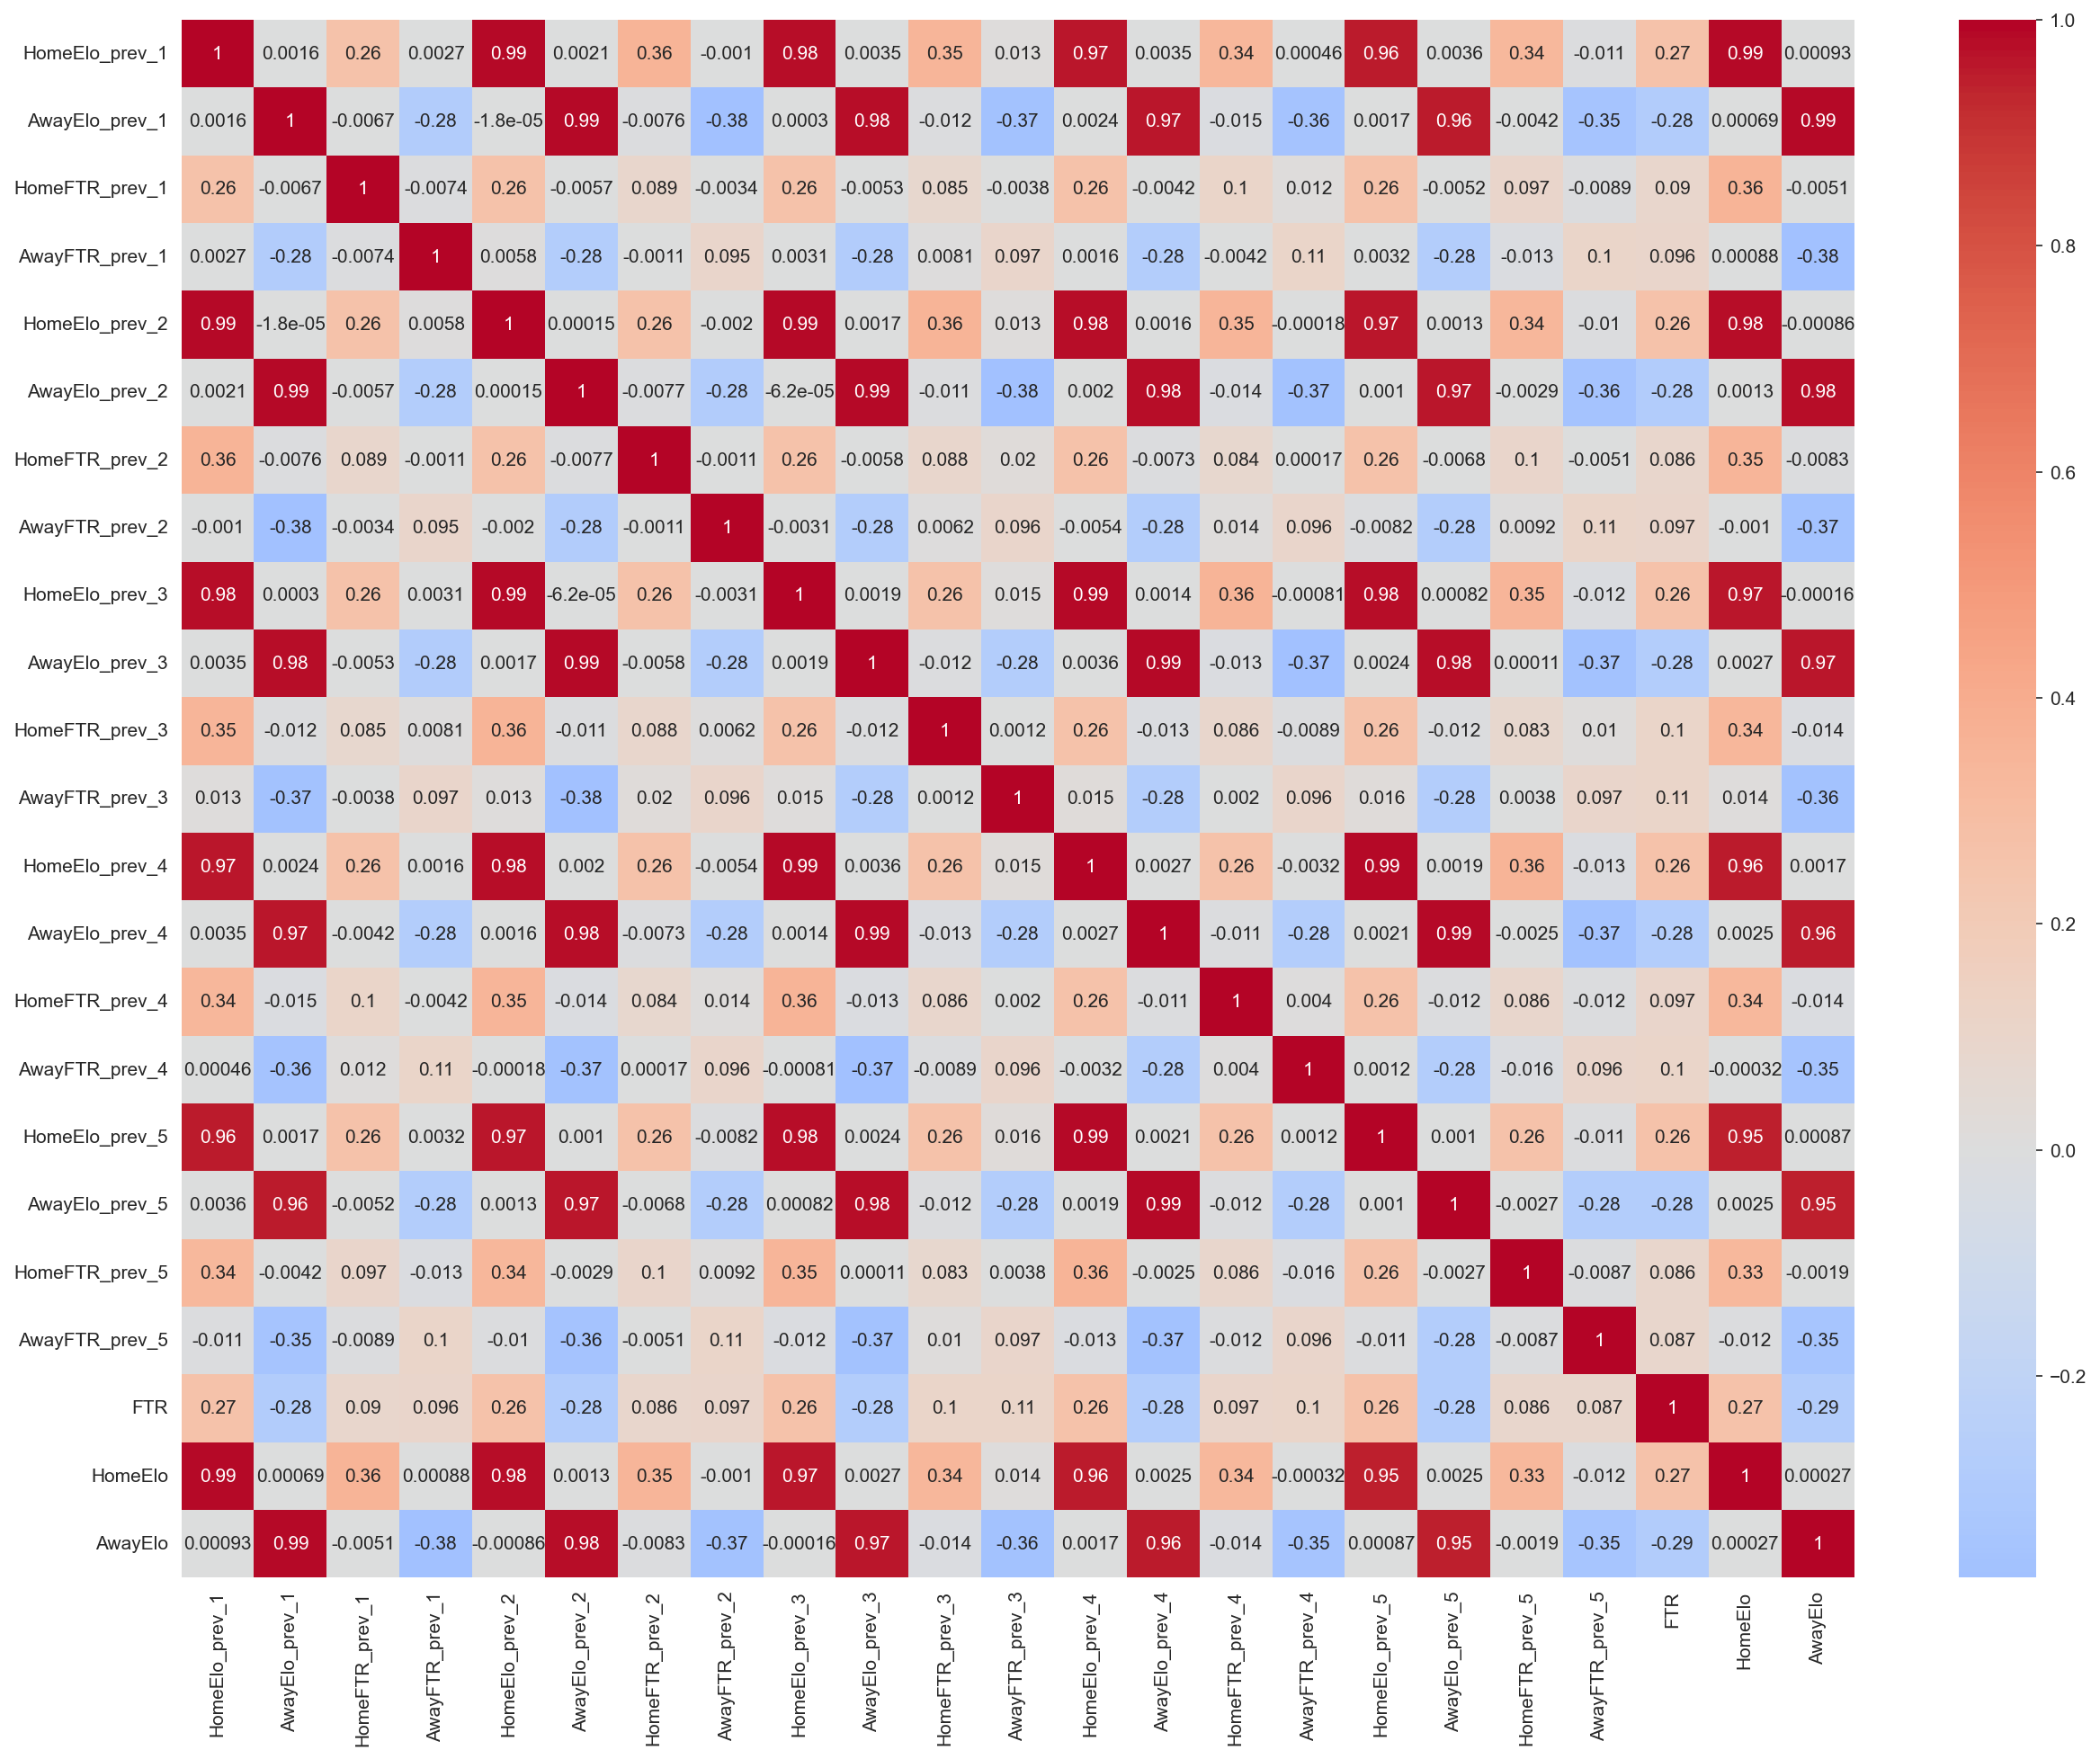

In [14]:
plt.figure(figsize=(20, 15), dpi=150)
sns.heatmap(df_with_history.drop(['HomeTeam', 'AwayTeam', 'Date'], axis=1).dropna().corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

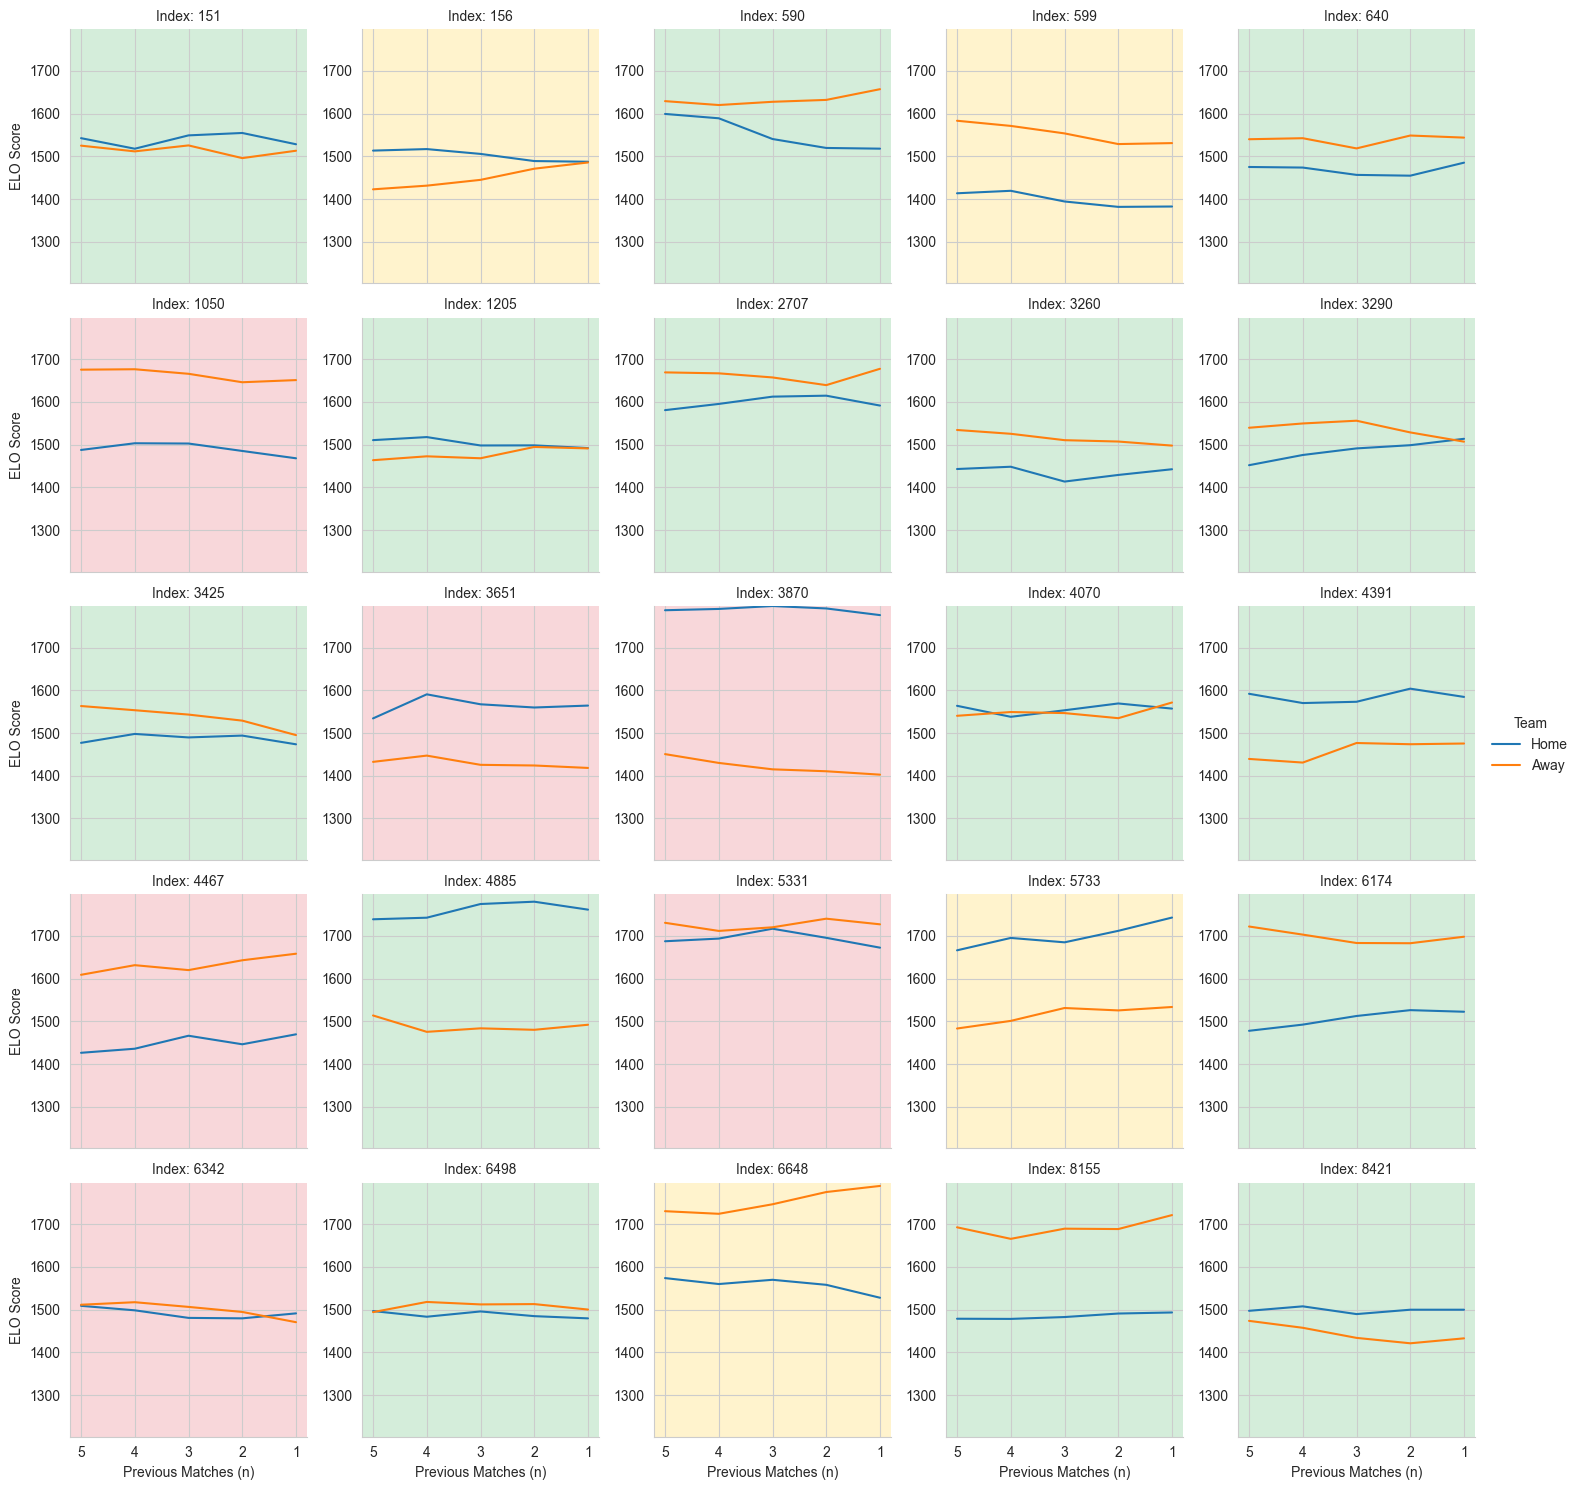

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_random_elo_histories(history_df, n, num_samples=25, center=1500):
    # Sample random indices
    random_indices = np.random.choice(history_df.index, size=num_samples, replace=False)

    # Initialize an empty DataFrame for plotting
    plot_data = pd.DataFrame()

    # Dictionary for FTR background colors
    ftr_colors = {1: '#d4edda', 0: '#fff3cd', -1: '#f8d7da'}

    # Variables to find the global ELO range
    global_min_elo, global_max_elo = float('inf'), float('-inf')

    for index in random_indices:
        row = history_df.iloc[index]

        # Extract FTR for the index (assuming 'FTR' column exists)
        ftr_value = row['FTR']

        # Prepare data for the home and away teams
        for team in ['Home', 'Away']:
            team_elo_history = [row[f'{team}Elo_prev_{i}'] for i in range(1, n+1)]
            team_data = pd.DataFrame({'Match Index': list(range(n, 0, -1)), 'ELO': team_elo_history, 'Team': team, 'Index': index, 'FTR': ftr_value})
            plot_data = pd.concat([plot_data, team_data])

            # Update global ELO range
            global_min_elo, global_max_elo = min(global_min_elo, min(team_elo_history)), max(global_max_elo, max(team_elo_history))

    # Calculate a y-axis range centered around center
    max_range = max(abs(global_max_elo - center), abs(global_min_elo - center))
    y_axis_limits = (center - max_range, center + max_range)

    # Create a FacetGrid
    g = sns.FacetGrid(plot_data, col='Index', col_wrap=5, hue='Team', sharey=False)

    # Apply background color and set y-axis limits
    for ax, idx in zip(g.axes.flatten(), random_indices):
        ax.set_facecolor(ftr_colors[history_df.loc[idx, 'FTR']])
        ax.invert_xaxis()
        ax.set_ylim(y_axis_limits)  # Set y-axis limits

    g.map(sns.lineplot, 'Match Index', 'ELO')

    # Adjust the titles and labels
    g.set_titles('Index: {col_name}')
    g.set_axis_labels('Previous Matches (n)', 'ELO Score')
    g.add_legend()

    plt.show()

# Example usage
plot_random_elo_histories(df_with_history, 5) # Replace 5 with the index of the row you want to plot


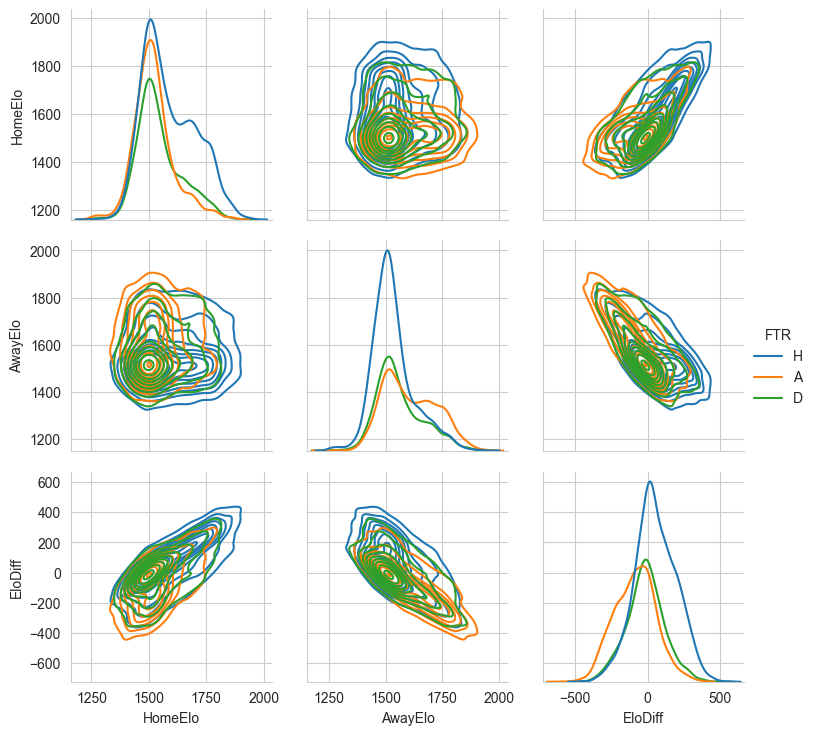

In [8]:
columns = ['HomeElo', 'AwayElo', 'EloDiff',
           'FTR']
g = sns.PairGrid(elo_df[columns], diag_sharey=False, hue="FTR")
g.map_offdiag(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

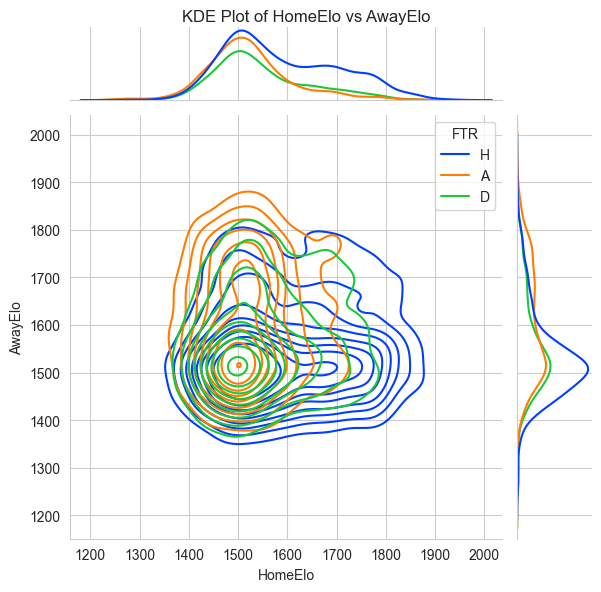

In [5]:
def draw_kde_plot(df, col_names):
    df = df.copy()
    
    # Draw a contour plot to represent each bivariate density
    g = sns.jointplot(
        data=df,
        x=col_names[0],
        y=col_names[1],
        hue="FTR",
        palette="bright",
        thresh=.1,
        kind="kde"
    )
    # Add a title
    g.fig.suptitle(f"KDE Plot of {col_names[0]} vs {col_names[1]}")
    
    # Adjust the title position to make sure it's visible (if necessary)
    g.fig.subplots_adjust(top=0.95)
    plt.show()
    

draw_kde_plot(elo_df, ["HomeElo", "AwayElo"])

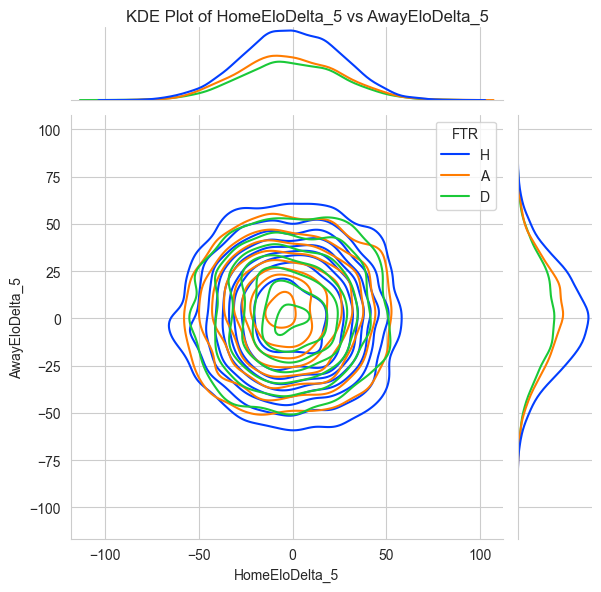

In [12]:
draw_kde_plot(elo_df, ["HomeEloDelta_5", "AwayEloDelta_5"])

<Axes: xlabel='FTR', ylabel='EloDiff'>

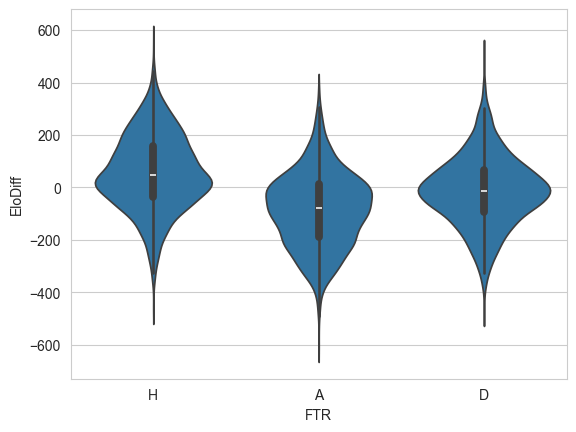

In [7]:
import seaborn as sns
sns.violinplot(data=elo_df, x="FTR", y="EloDiff")

C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\3868416265.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\3868416265.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_away['Date'] = pd.to_datetime(team_away['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\3868416265.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\

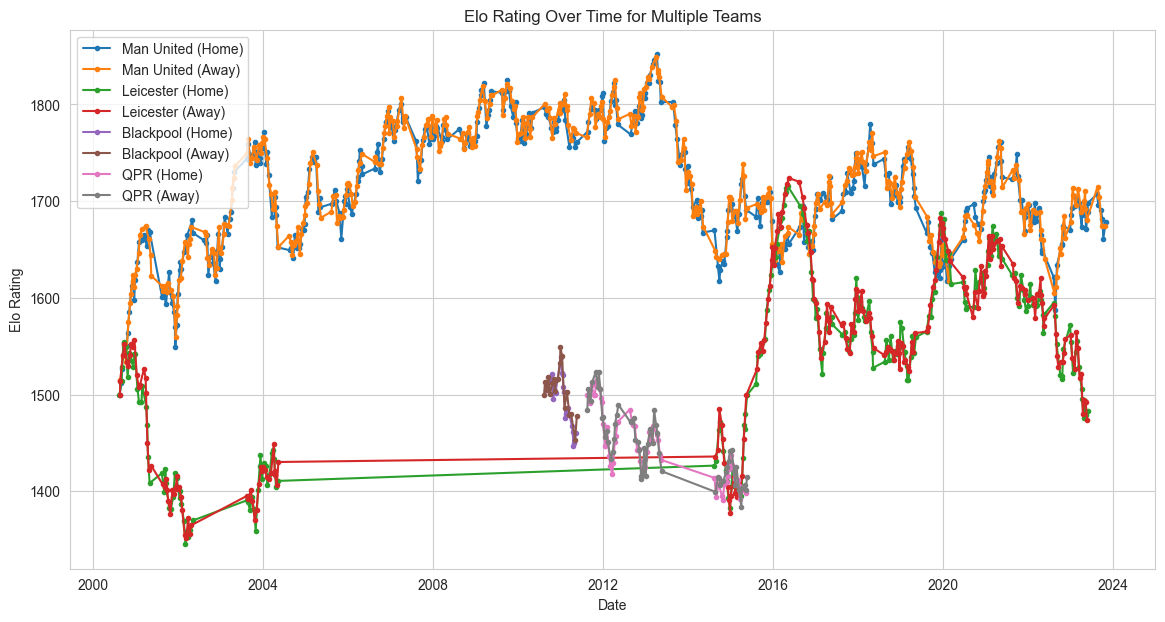

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = epl_training_df.copy()

# Assuming `df` is your dataframe with the updated Elo scores
# And `teams` is a list of team names whose Elo changes you want to plot
teams = ['Man United', 'Leicester', 'Blackpool', "QPR"]  # Example list of teams

plt.figure(figsize=(14, 7))

for team in teams:
    # Filter the dataframe for matches involving the current team
    # Create copies to avoid SettingWithCopyWarning
    team_home = df[df['HomeTeam'] == team].copy()
    team_away = df[df['AwayTeam'] == team].copy()

    # Direct assignment to the column
    team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
    team_away['Date'] = pd.to_datetime(team_away['Date'], dayfirst=True)

    team_home = team_home.sort_values('Date')
    team_away = team_away.sort_values('Date')

    # Plot the Elo scores
    plt.plot(team_home['Date'], team_home['HomeElo'], marker='.', label=f"{team} (Home)")
    plt.plot(team_away['Date'], team_away['AwayElo'], marker='.', label=f"{team} (Away)")

plt.title('Elo Rating Over Time for Multiple Teams')
plt.xlabel('Date')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_away['Date'] = pd.to_datetime(team_away['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\

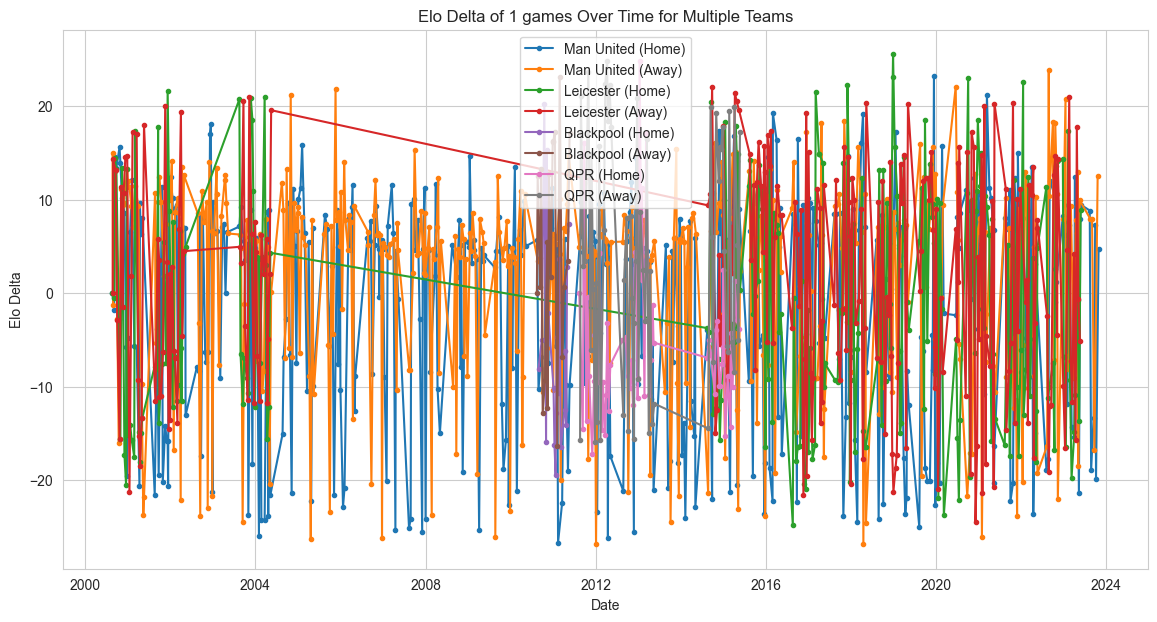

C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_away['Date'] = pd.to_datetime(team_away['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\

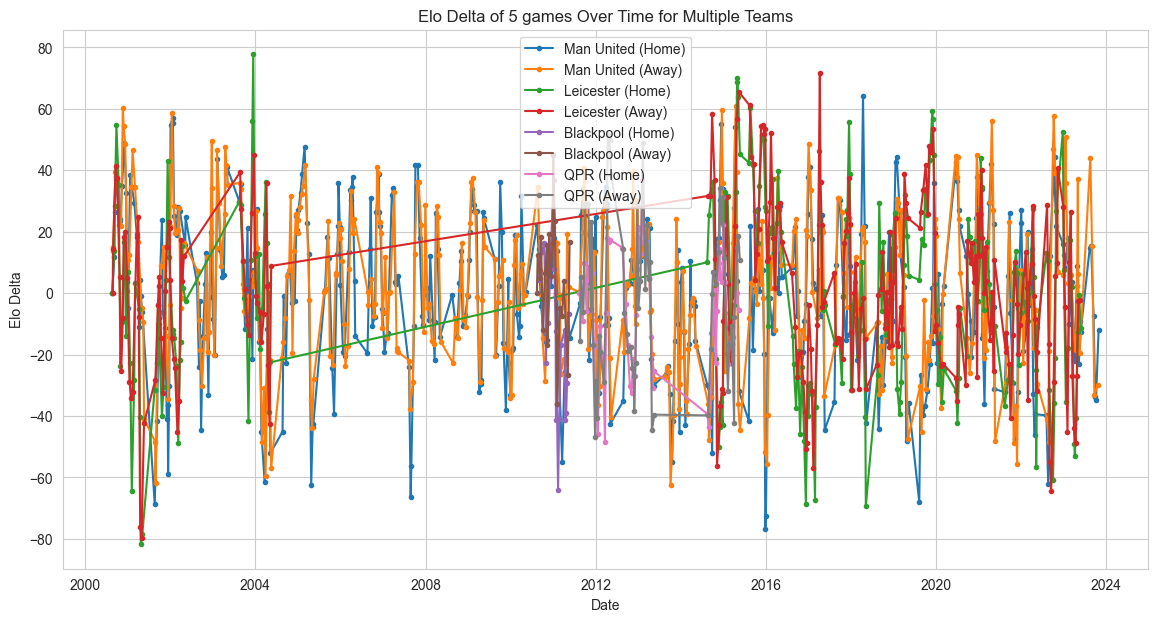

C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_away['Date'] = pd.to_datetime(team_away['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\ipykernel_5768\4088609653.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
C:\Users\jerew\AppData\Local\Temp\

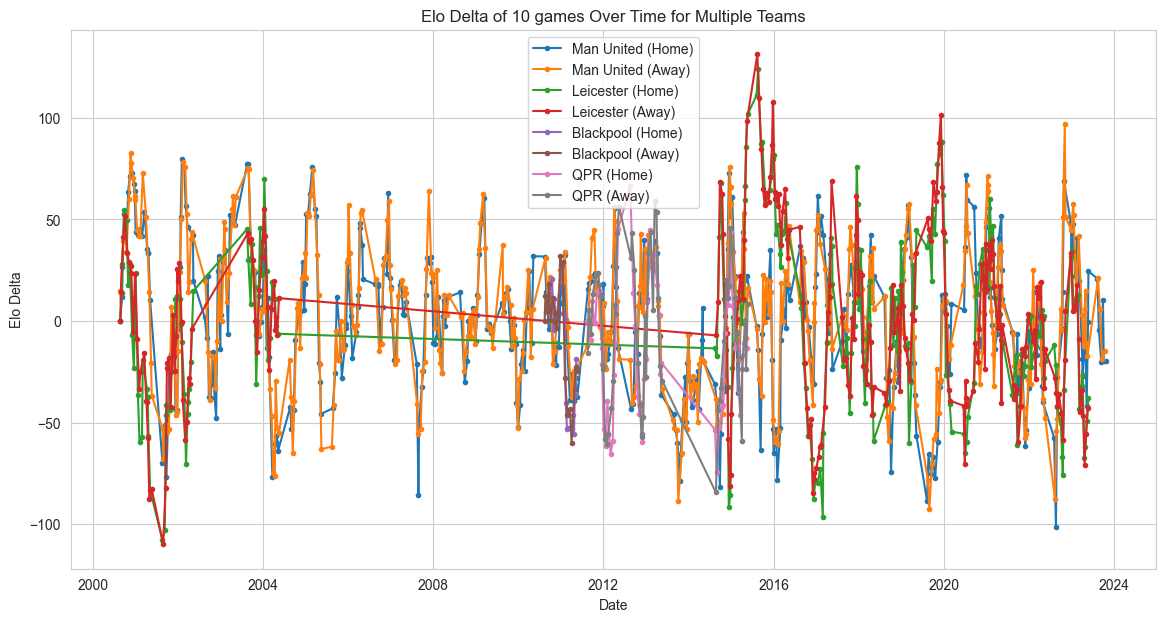

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_elo_delta(delta_num):
  df = epl_training_df.copy()

  # Assuming `df` is your dataframe with the updated Elo scores
  # And `teams` is a list of team names whose Elo changes you want to plot
  teams = ['Man United', 'Leicester', 'Blackpool', "QPR"]  # Example list of teams

  plt.figure(figsize=(14, 7))

  for team in teams:
      # Filter the dataframe for matches involving the current team
      # Create copies to avoid SettingWithCopyWarning
      team_home = df[df['HomeTeam'] == team].copy()
      team_away = df[df['AwayTeam'] == team].copy()

      # Direct assignment to the column
      team_home['Date'] = pd.to_datetime(team_home['Date'], dayfirst=True)
      team_away['Date'] = pd.to_datetime(team_away['Date'], dayfirst=True)

      team_home = team_home.sort_values('Date')
      team_away = team_away.sort_values('Date')

      # Plot the Elo scores
      plt.plot(team_home['Date'], team_home[f'HomeEloDelta_{delta_num}'], marker='.', label=f"{team} (Home)")
      plt.plot(team_away['Date'], team_away[f'AwayEloDelta_{delta_num}'], marker='.', label=f"{team} (Away)")

  plt.title(f'Elo Delta of {delta_num} games Over Time for Multiple Teams')
  plt.xlabel('Date')
  plt.ylabel('Elo Delta')
  plt.legend()
  plt.grid(True)
  plt.show()

for i in [1, 5, 10]:
  plot_elo_delta(i)

### use accuracy

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Sample DataFrame
df = elo_df.copy()

# Drop rows with NaN values and explicitly create a new copy
df = df.dropna().copy()

# Encode the 'FTR' column
target_column = 'FTR'
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])  # W, D, L becomes 0, 1, 2

# Features and Target
X = df.drop(target_column, axis=1)
y = df[target_column]

# Define 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression Model with Cross-Validation
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_scores = cross_val_score(logistic_model, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

# Random Forest Classifier Model with Cross-Validation
random_forest_model = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(random_forest_model, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

# XGBoost Classifier Model with Cross-Validation
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgboost_scores = cross_val_score(xgboost_model, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

# Displaying the results
print(f"Logistic Regression CV Accuracy: {logistic_scores.mean():.4f} (+/- {logistic_scores.std() * 2:.4f})")
print(f"Random Forest CV Accuracy: {forest_scores.mean():.4f} (+/- {forest_scores.std() * 2:.4f})")
print(f"XGBoost CV Accuracy: {xgboost_scores.mean():.4f} (+/- {xgboost_scores.std() * 2:.4f})")


ModuleNotFoundError: No module named 'xgboost'

## Train test split

In [18]:
# To predict and get probabilities
# Example Elo ratings for prediction

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df = elo_df.dropna().copy()

# Specify the name of the target column
target_column = 'FTR'  # Replace with the name of your target column

# Features and Target
X = df.drop(target_column, axis=1)  # Features
X = df[['HomeElo', 'AwayElo']]
X = scaler.fit_transform(X)
y = df[target_column]               # Target

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Creating and training the logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, penalty='l2')
logistic_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = logistic_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.5361990950226244
Classification Report:
               precision    recall  f1-score   support

           A       0.55      0.51      0.53       590
           D       1.00      0.00      0.00       398
           H       0.53      0.83      0.65       780

    accuracy                           0.54      1768
   macro avg       0.69      0.45      0.39      1768
weighted avg       0.64      0.54      0.46      1768


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Assuming elo_df is your DataFrame with features and target
df = elo_df.dropna().copy()

# Specify the name of the target column
target_column = 'FTR'  # Replace with the name of your target column

# Features and Target
X = df.drop(target_column, axis=1)  # Features
y = df[target_column]               # Target

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the XGBoost model
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# Plotting feature importance
plot_importance(xgboost_model)
plt.show()


y_pred = xgboost_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume 'df' is your DataFrame
df = elo_df.copy()

# 1. Preprocess the Data
features = df[['HomeElo', 'AwayElo', 'EloDiff']].values
labels = df['FTR'].values

scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# 2. Create Dataset and DataLoader
class MatchDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = MatchDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 3. Define the Neural Network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(3, 64) # 3 input features
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 3) # 3 output classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNet()

# 4. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 6. Evaluation
# Split the dataset into train and test sets to evaluate the model


Epoch [1/1000], Loss: 0.8669
Epoch [2/1000], Loss: 0.9010
Epoch [3/1000], Loss: 1.0731
Epoch [4/1000], Loss: 0.9748
Epoch [5/1000], Loss: 1.0454
Epoch [6/1000], Loss: 0.7790
Epoch [7/1000], Loss: 0.9222
Epoch [8/1000], Loss: 1.2396
Epoch [9/1000], Loss: 0.9439
Epoch [10/1000], Loss: 0.8731
Epoch [11/1000], Loss: 0.6989
Epoch [12/1000], Loss: 0.9616
Epoch [13/1000], Loss: 1.0430
Epoch [14/1000], Loss: 0.8825
Epoch [15/1000], Loss: 1.1099
Epoch [16/1000], Loss: 0.9039
Epoch [17/1000], Loss: 0.9856
Epoch [18/1000], Loss: 1.0650
Epoch [19/1000], Loss: 0.7144
Epoch [20/1000], Loss: 0.9961
Epoch [21/1000], Loss: 1.0279
Epoch [22/1000], Loss: 1.1396
Epoch [23/1000], Loss: 1.2914
Epoch [24/1000], Loss: 1.4246
Epoch [25/1000], Loss: 0.9729
Epoch [26/1000], Loss: 1.2211
Epoch [27/1000], Loss: 0.9833
Epoch [28/1000], Loss: 1.0246
Epoch [29/1000], Loss: 1.1984
Epoch [30/1000], Loss: 0.8351
Epoch [31/1000], Loss: 0.9125
Epoch [32/1000], Loss: 0.8921
Epoch [33/1000], Loss: 0.9655
Epoch [34/1000], Lo

KeyboardInterrupt: 